In [9]:
import requests
import PIL.Image as Image
import getpass
import time
import os
import json
import io
import matplotlib.pyplot as plt

In [3]:
api_key = 'sk-iXZRGtpEuejm11gX8VIHLo9DT2HcOyEncjSGgf1y54msjybQ'
STABILITY_KEY = getpass.getpass(api_key)

In [4]:
#@title Define functions

def send_generation_request(
    host,
    params,
):
    headers = {
        "Accept": "image/*",
        "Authorization": f"Bearer {STABILITY_KEY}"
    }

    # Encode parameters
    files = {}
    image = params.pop("image", None)
    mask = params.pop("mask", None)
    if image is not None and image != '':
        files["image"] = open(image, 'rb')
    if mask is not None and mask != '':
        files["mask"] = open(mask, 'rb')
    if len(files)==0:
        files["none"] = ''

    # Send request
    print(f"Sending REST request to {host}...")
    response = requests.post(
        host,
        headers=headers,
        files=files,
        data=params
    )
    if not response.ok:
        raise Exception(f"HTTP {response.status_code}: {response.text}")

    return response

def send_async_generation_request(
    host,
    params,
):
    headers = {
        "Accept": "application/json",
        "Authorization": f"Bearer {STABILITY_KEY}"
    }

    # Encode parameters
    files = {}
    if "init_image" in params:
        init_image = params.pop("init_image")
        files = {"image": open(init_image, 'rb')}

    # Send request
    print(f"Sending REST request to {host}...")
    response = requests.post(
        host,
        headers=headers,
        files=files,
        data=params
    )
    if not response.ok:
        raise Exception(f"HTTP {response.status_code}: {response.text}")

    # Process async response
    response_dict = json.loads(response.text)
    generation_id = response_dict.get("id", None)
    assert generation_id is not None, "Expected id in response"

    # Loop until result or timeout
    timeout = int(os.getenv("WORKER_TIMEOUT", 500))
    start = time.time()
    status_code = 202
    while status_code == 202:
        response = requests.get(
            f"{host}/result/{generation_id}",
            headers={
                **headers,
                "Accept": "image/*"
            },
        )

        if not response.ok:
            raise Exception(f"HTTP {response.status_code}: {response.text}")
        status_code = response.status_code
        time.sleep(10)
        if time.time() - start > timeout:
            raise Exception(f"Timeout after {timeout} seconds")

    return response

In [6]:
original_image = "saw.jpg" #@param {type:"string"}
output_format = "webp" #@param ["webp", "jpeg", "png"]

host = f"https://api.stability.ai/v2beta/stable-image/edit/remove-background"

params = {
    "image" : original_image,
    "output_format": output_format
}

response = send_generation_request(
    host,
    params
)

# Decode response
output_image = response.content
finish_reason = response.headers.get("finish-reason")
seed = response.headers.get("seed")

# Check for NSFW classification
if finish_reason == 'CONTENT_FILTERED':
    raise Warning("Generation failed NSFW classifier")

# Save and display result
filename, _ = os.path.splitext(os.path.basename(original_image))
edited = f"edited_{filename}_{seed}.{output_format}"

Sending REST request to https://api.stability.ai/v2beta/stable-image/edit/remove-background...


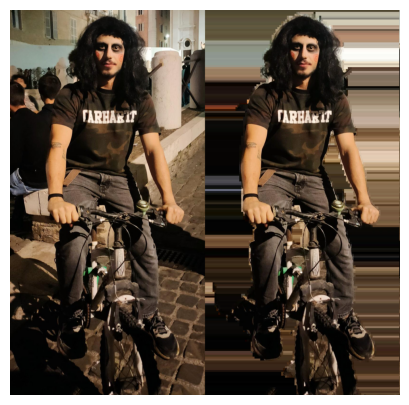

In [10]:
immagine_originale = Image.open(original_image)
immagine_modificata = Image.open(io.BytesIO(output_image))

larghezza1, altezza1 = immagine_originale.size
larghezza2, altezza2 = immagine_modificata.size

larghezza_combinata = larghezza1 + larghezza2
altezza_massima = max(altezza1, altezza2)
immagine_combinata = Image.new('RGB', (larghezza_combinata, altezza_massima))

immagine_combinata.paste(immagine_originale, (0, 0))
immagine_combinata.paste(immagine_modificata, (larghezza1, 0))

plt.figure(figsize=(10, 5)) 
plt.imshow(immagine_combinata)
plt.axis('off')
plt.show()